# Reinforment Learning Snake 

In [26]:
%pip install -q tensorflow-gpu gym keras keras-rl2 pyvirtualdisplay pyglet pygame

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os

from collections import defaultdict
from envs import SnakeWorldEnv
from gym import Env
from gym.spaces import Discrete, Box
from gym import core, spaces
from gym.error import DependencyNotInstalled
from typing import Optional
import numpy as np
import random
import matplotlib.pyplot as plt
import pyvirtualdisplay
import PIL.Image
from gym.wrappers import RecordVideo
import tensorflow as tf    


In [28]:
# Allow the graphic window to exist without having to rendered to the display. Aka add support for headless graphic, when using a OpenGL rendering library.
display = pyvirtualdisplay.Display(visible=0, size=(1280, 720)).start()

## Snake World

In [92]:
class SnakeWorldEnv(Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 15}
    metadata = {"render_modes": ["human", "ansi", "rgb_array"], "render_fps": 4}

    SCREEN_SCALE = 30.0
    SCREEN_DIM = 28 * SCREEN_SCALE

    def __init__(self, nrObsticles=4, world_size=(28, 28)):

        self.screen = None
        self.clock = None
        self.isopen = True
        self.world_size = (28, 28)

        # Actions we can take, down, stay, up
        self.action_space = Discrete(4)
        self.observation_space = Box(low=-1, high=1, shape=(2, 1), dtype=np.float32)

        # World Space
        self.state = np.zeros(shape=world_size).astype(dtype='float32')

        self.snake_length = 3
        self.snake_head_position = (0, 0)
        self.apple_position = (0, 0)
        self.last_time_grown = 0
        self.snake_body = []

    def step(self, action):

        done = False
        reward = 0
        apple_consumed = False

        current_distance_from_apple = np.linalg.norm(self.apple_position - self.snake_head_position)
        # Update params.
        # Apply action
        # Remove head from previous.
        self.state[int(self.snake_head_position[0]), int(self.snake_head_position[1])] = 0
        # Move the last sequence to the next position.
        if action == 0:
            self.snake_head_position += np.array([1, 0])
        if action == 1:
            self.snake_head_position += np.array([-1, 0])
        if action == 2:
            self.snake_head_position += np.array([0, 1])
        if action == 3:
            self.snake_head_position += np.array([0, -1])

        if self.snake_head_position[0] >= self.state.shape[0] or self.snake_head_position[0] < 0:
            done = True
            reward = 0
        elif self.snake_head_position[1] >= self.state.shape[1] or self.snake_head_position[1] < 0:
            done = True
            reward = 0

        if not done:
            # Update new position
            self.state[int(self.snake_head_position[0]), int(self.snake_head_position[1])] = 255

            #
            self.last_time_grown += 1

            # If snake overlap.
            next_distance_from_apple = np.linalg.norm(self.apple_position - self.snake_head_position)

            reward = (1.0 / max(1.0, np.linalg.norm(self.apple_position - self.snake_head_position))) * 0.25
            # Reward negative going away.
            if next_distance_from_apple > current_distance_from_apple:
                reward = -reward

            if self.state[self.apple_position[0], self.apple_position[1]] == 255:
                apple_consumed = True
            # Calculate reward
            # If closer. small reward, get apple. big reward.
            if apple_consumed:
                reward += 20
                self.snake_length += 1
                self.last_time_grown = 0

                self._reset_level()

                # Update apple position
                self.state[self.apple_position[0], self.apple_position[1]] = 0
                self.apple_position = np.random.randint(size=(2,), low=0, high=28)
                self.state[self.apple_position[0], self.apple_position[1]] = -255
            else:
                # Check if timeout.
                if self.last_time_grown >= 500 - self.snake_length:
                    done = True
                    reward = 0
                else:
                    done = False

        # Set placeholder for info
        info = {}

        Appledir = (self.apple_position - self.snake_head_position)
        distance = np.linalg.norm(Appledir)
        if distance > 0:
            Appledir = Appledir / np.linalg.norm(Appledir)
        else:
            Appledir = np.array([0, 0])

        # Return step information
        return Appledir, reward, done, info

    def _reset_level(self):
        pass

    def reset(self):
        self.snake_length = 3
        self.snake_head_position = np.asarray(self.state.shape, dtype=int) / 2
        self.snake_last_position = np.asarray(self.snake_head_position - (0, 3))

        self.state = np.zeros(shape=self.state.shape).astype(dtype='float32')

#        for x in range(0, self.snake_length):
        self.state[int(self.snake_head_position[0]), int(self.snake_head_position[1])] = 255

        self.apple_position = np.random.randint(size=(2,), low=0, high=28)
        self.state[self.apple_position[0], self.apple_position[1]] = -255
        self.last_time_grown = 0

        Appledir = (self.apple_position - self.snake_head_position)
        distance = np.linalg.norm(Appledir)
        if distance > 0:
            Appledir = Appledir / np.linalg.norm(Appledir)
        else:
            Appledir = np.array([0, 0])

        #result = np.squeeze(np.array(self.state.flatten(), dtype=np.float32))

        self._reset_level()

        return np.array([0, 0])

    def render(self, mode="human"):
        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            pygame.display.init()
            pygame.display.set_caption("Frozen Lake")
            if mode == "human":
                self.window_surface = pygame.display.set_mode((self.SCREEN_DIM, self.SCREEN_DIM))
            else:  # rgb_array
                self.window_surface = pygame.Surface(self.window_size)

        if self.clock is None:
            self.clock = pygame.time.Clock()
        # Load asset if not loaded.

        # Draw enviroment.

        self.surf = pygame.Surface((self.SCREEN_DIM, self.SCREEN_DIM))
        self.surf.fill((128, 128, 128))
        s = self.state

        # pygame.draw.
        pygame.draw.circle(self.surf, (0, 255, 0), np.asarray(self.apple_position) * self.SCREEN_SCALE, self.SCREEN_SCALE * 0.5)
        pygame.draw.circle(self.surf, (255, 0, 0), np.asarray(self.snake_head_position) * self.SCREEN_SCALE, self.SCREEN_SCALE * 0.5)

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))

        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        if mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )
        else:
            return self.isopen

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


In [93]:
env = SnakeWorldEnv(world_size=(10,10))

## Example Of Enviroment

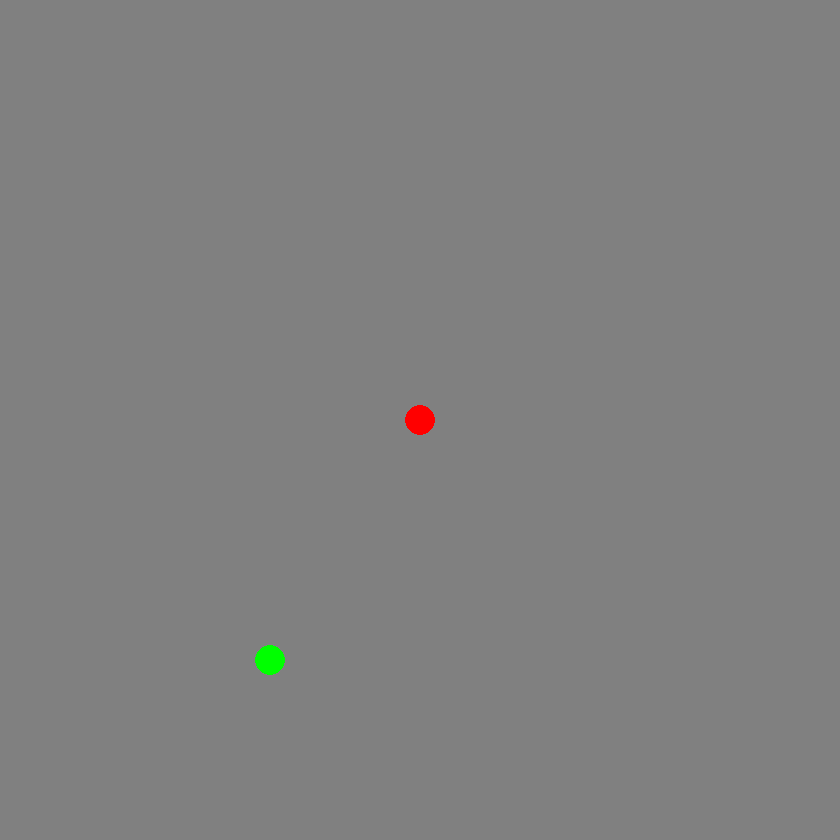

In [94]:
env.reset()
PIL.Image.fromarray(env.render(mode="rgb_array"))


## 

In [97]:
observation = env.reset()
print(observation.shape, observation.dtype)

(2,) int64


In [99]:
states = env.observation_space.shape
actions = env.action_space.n

In [100]:
actions


4

In [101]:
states

(2, 1)

## Q Learning Tabular
The simple as well the naive approuch for deterministic spaces. 

$$Q(S,A_t) = Q(S,A_t) + \alpha (r + \gamma \max_a Q(S',a) ) $$


In [ ]:
# Video Recorder.

In [ ]:
class DiscretizedObservationWrapper(gym.ObservationWrapper):
    """This wrapper converts a Box observation into a single integer.
    """
    def __init__(self, env, n_bins=10, low=None, high=None):
        super().__init__(env)
        assert isinstance(env.observation_space, Box)

        low = self.observation_space.low if low is None else low
        high = self.observation_space.high if high is None else high

        self.n_bins = n_bins
        self.val_bins = [np.linspace(l, h, n_bins + 1) for l, h in
                         zip(low.flatten(), high.flatten())]
        self.observation_space = Discrete(n_bins ** low.flatten().shape[0])

    def _convert_to_one_number(self, digits):
        return sum([d * ((self.n_bins + 1) ** i) for i, d in enumerate(digits)])

    def observation(self, observation):
        digits = [np.digitize([x], bins)[0]
                  for x, bins in zip(observation.flatten(), self.val_bins)]
        return self._convert_to_one_number(digits)




In [ ]:
def QLearning(env, learning_rate, n_steps,epsilon=0.1, gamma=0.99):

    Q = defaultdict(float)
    gamma = 0.99  # Discounting factor
    alpha = 0.5  # soft update param

    def update_Q(s, r, a, s_next, done):
        max_q_next = max([Q[s_next, a] for a in actions]) 
        # Do not include the next state's value if currently at the terminal state.
        Q[s, a] += alpha * (r + gamma * max_q_next * (1.0 - done) - Q[s, a])

    n_steps = 100000

    def act(ob):
        if np.random.random() < epsilon:
            # action_space.sample() is a convenient function to get a random action
            # that is compatible with this given action space.
            return env.action_space.sample()

        # Pick the action with highest q value.
        qvals = {a: Q[ob, a] for a in actions}
        max_q = max(qvals.values())
        # In case multiple actions have the same maximum q value.
        actions_with_max_q = [a for a, q in qvals.items() if q == max_q]
        return np.random.choice(actions_with_max_q)
    
    ob = env.reset()
    rewards = []
    reward = 0.0

    for step in range(n_steps):
        a = act(ob)
        ob_next, r, done, _ = env.step(a)
        update_Q(ob, r, a, ob_next, done)
        reward += r

        if done:
            rewards.append(reward)
            reward = 0.0
            ob = env.reset()
        else:
            ob = ob_next

    return rewards

In [ ]:
DiscreteEnv = DiscretizedObservationWrapper(
    env,
    n_bins=8,
    low=[-2.4, -2.0, -0.42, -3.5],
    high=[2.4, 2.0, 0.42, 3.5]
)
hyperparamers = {"steps": [10000,50000,100000], "learning_rate": [0.001,0.005], "epsilon" : [0.15,0.1,0.5, 0.1 0.05], "gamma": [0.9, 0.95, 0.99, 1.0] }

DiscreteEnv = RecordVideo(DiscreteEnv, video_folder='FrozenLake/QLearning', step_trigger=lambda e: True)
DiscreteEnv.start_video_recorder()

for steps in hyperparamers.steps:
    for learning_rate in hyperparamers.learning_rate:
        for epsilon in hyperparamers.epsilon:
            for gamma in hyperparamers.gamma:
                rewards = QLearning(DiscreteEnv,n_steps=steps,learning_rate=learning_rate,epsilon=epsilon,gamma=gamma)

            # Generate result data


DiscreteEnv.close_video_recorder()

## Result

## DNQ Learning - Deep Q Learning

In [98]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras


In [102]:
WINDOW_LENGTH = 6
def build_model(states, actions):
    model = Sequential(name="")
    # Sum all dims to the final
    model.add(keras.layers.Input((WINDOW_LENGTH, np.prod(states))))
    model.add(keras.layers.Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(keras.layers.BatchNormalization(dtype='float32'))

    model.add(Dense(units=16, activation='relu'))
    model.add(keras.layers.BatchNormalization(dtype='float32'))
    model.add(Dense(units=actions, activation='linear'))
    return model


In [103]:
del model 
model = build_model(env.observation_space.shape, actions)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 12)                0         
                                                                 
 dense_24 (Dense)            (None, 32)                416       
                                                                 
 batch_normalization_16 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 batch_normalization_17 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 4)                

In [104]:
from rl.agents import DQNAgent, DDPGAgent
from rl.policy import BoltzmannQPolicy, MaxBoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory, EpisodeParameterMemory

In [105]:
def build_agent(model, actions):

    GAMMA = 0.98           # discount factor
    BUFFER_SIZE = 100000   # replay buffer size
    BATCH_SIZE = 64        # Update batch size
    LR = 0.0001            # learning rate
    TAU = 1e-3             # for soft update of target parameters
    UPDATE_EVERY = 1       # how often to update the network
    UPDATE_TARGET = 10000  # After which thershold replay to be started
    EPS_START = 0.99       # starting value of epsilon
    EPS_END = 0.01         # Ending value of epsilon
    EPS_DECAY = 100         # Rate by which epsilon to be decayed

    policy = BoltzmannQPolicy()#(clip=(0., 1.))

    memory = SequentialMemory(limit=50000, window_length=WINDOW_LENGTH)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, enable_double_dqn=False, enable_dueling_network=False,
                   nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2, gamma=GAMMA)
    return dqn


In [ ]:
with tf.device('/gpu:0'):
    dqn = build_agent(model, actions)
    dqn.compile(Adam(learning_rate=8e-3), metrics=['mae'])

    dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

env.close_video_recorder()

## Convolutional DNQ Learning